In [1]:
import pandas as pd
import torch
from BugBuster import BugBuster
from torch.utils.data import DataLoader
from ARGDataset import ARGDataset
import helper_functions
from matplotlib import pyplot as plt

/home/jmontour15/miniconda3/envs/faesm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Usage Guide
This notebook will take you through how to use BugBuster to predict the antibiotic resistance conferrence of one or many proteins, and extract the motifs meaningful for this classification.
1. [Classificaion](#classification-guide)
2. [Explainability](#explainability)
3. [Motif Plots](#motif-extraction-guide)

### Setup
First, we need to load our model and data. I have selected two resistance conferring proteins and two unrelated bacterial proteins which have not been used in training data. Included in the CSV is also a brief description of the protein and a link to the NCBI reference for that protein.

In [2]:
# Load data
data = pd.read_csv("Data/usage_example_data.csv", usecols=[0,1,2,3])
data.head()

sequence  label  \
0  MEETFFEDLSLEKEDFTHKYLEKGEYENCKFSNCNFSNSDLSSIRF...      1   
1  MFSVLKKLGWFFKAYWLRYTIAIVLLLAVNVIEMFPPKLLGNAIDD...      1   
2  MNRQSTKKALLIPFVIMIITAIVLMGVWFIFNSLIALIASIVLVVM...      0   
3  MNLLSLLLILLGIILGVVGGYVVARNLLLQKQSQARQTAEDIVNQA...      0   

                                         description  \
0  antibiotic resistant protein MCBG [Flavobacter...   
1                              multidrug efflux pump   
2                    cyclic-di-AMP phosphodiesterase   
3                 staphylococcus aureus ribonuclease   

                                                link  
0    https://www.ncbi.nlm.nih.gov/protein/EAS19562.1  
1  https://www.ncbi.nlm.nih.gov/protein/O07550.1?...  
2  https://www.ncbi.nlm.nih.gov/protein/WP_411896...  
3    https://www.ncbi.nlm.nih.gov/protein/OBX96318.1

### Loading Model
In order to load a trained BugBuster model we need to set some things up

In [3]:
# Access system GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize new model
model = BugBuster(num_mlm_layers=6, num_classes=1, num_heads=8, num_layers=2, dropout=0.2, freeze_mlm = False)
model.to(device)

# Load pretrained weights
checkpoint = torch.load("trained_checkpoints/unfrozen_mlm6_heads8_layers2.pth", weights_only=True)

# Initialize model with pretrained weights
model.load_state_dict(checkpoint)

# Create datasets
dataset = ARGDataset(data['sequence'], data['label'])

### Collate Function
A collate function is necessary for sequences that are not the same length, this will add padding to the shorter sequences so that they are all uniform length. The collate function also creates an attention mask so that the model knows to ignore the padding added in this step.

In [4]:
# Access model's batch_converter
batch_converter = model.batch_converter

def collate_fn(batch):
    """
    Custom collate function that tokenizes sequences using ESM's batch_converter 
    and generates an attention mask.
    """
    sequences, labels = zip(*batch)  # Unpack sequences and labels
    
    # Convert batch to tokenized tensors with padding
    batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(range(len(sequences)), sequences)))

    # Create attention mask: 1 for valid tokens, 0 for padding
    attention_mask = (batch_tokens != 1).long()

    return batch_tokens, attention_mask, torch.tensor(labels, dtype=torch.long)

In [5]:
# Initialize DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn = collate_fn)

### Classification
Now that we have our model and data, we can make predictions on our sample data. The sample data was collected by randomly selecting two antibiotic resistance proteins and two random bacterial proteins from the NCBI Protein Database.

In [6]:
actual, predicted = helper_functions.make_predictions(model, dataloader, device)
for i in range(len(actual)):
    print(f"Protein: {data['description'].iloc[i]}")
    print(f"True Resistance: {'Resistant' if actual[i] == 1 else 'Susceptible'}")
    print(f"Predicted Resistance: {'Resistant' if predicted[i] == 1 else 'Susceptible'}\n")

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]

Protein: antibiotic resistant protein MCBG [Flavobacteria bacterium BBFL7]
True Resistance: Resistant
Predicted Resistance: Resistant

Protein: multidrug efflux pump
True Resistance: Resistant
Predicted Resistance: Resistant

Protein: cyclic-di-AMP phosphodiesterase
True Resistance: Susceptible
Predicted Resistance: Susceptible

Protein: staphylococcus aureus ribonuclease
True Resistance: Susceptible
Predicted Resistance: Susceptible



### Results
It looks like the model manages to correctly predict all four proteins! While this does not especially challenge our model, these results are promising and absolutely confirm the ability of deep learning and transformer models when it comes to protein classification.

### Explainability
Transformer architectures are especially useful due to their attention mechanisms, which are not only very powerful for performance, but can aso be valuable for model interpretation and visualization. To show this, our model has the capability to display attention weight matrices, which can then be converted to motif plots to better represent importance values placed on amino acids throughout the sequence.

In [7]:
# Accessing weights
for sequences, attention_masks, labels in dataloader:
    print(sequences.shape)
    print(attention_masks.shape)
    print(labels.shape)
    sequences = sequences.to(device)
    attention_masks = attention_masks.to(device)
    with torch.no_grad():
        weights = model.get_attention_weights(sequences, attention_masks, need_head_weights=True)
    break # Only access first batch

torch.Size([4, 657])
torch.Size([4, 657])
torch.Size([4])
torch.Size([4, 657, 320])


In [8]:
# Shape: [batch_size, num_layers, num_heads, sequence_length, sequence_length]
print(weights["MLM_weights"].shape)
print(weights["task_specific_head_weights"].shape)

torch.Size([4, 6, 20, 657, 657])
torch.Size([4, 2, 8, 657, 657])


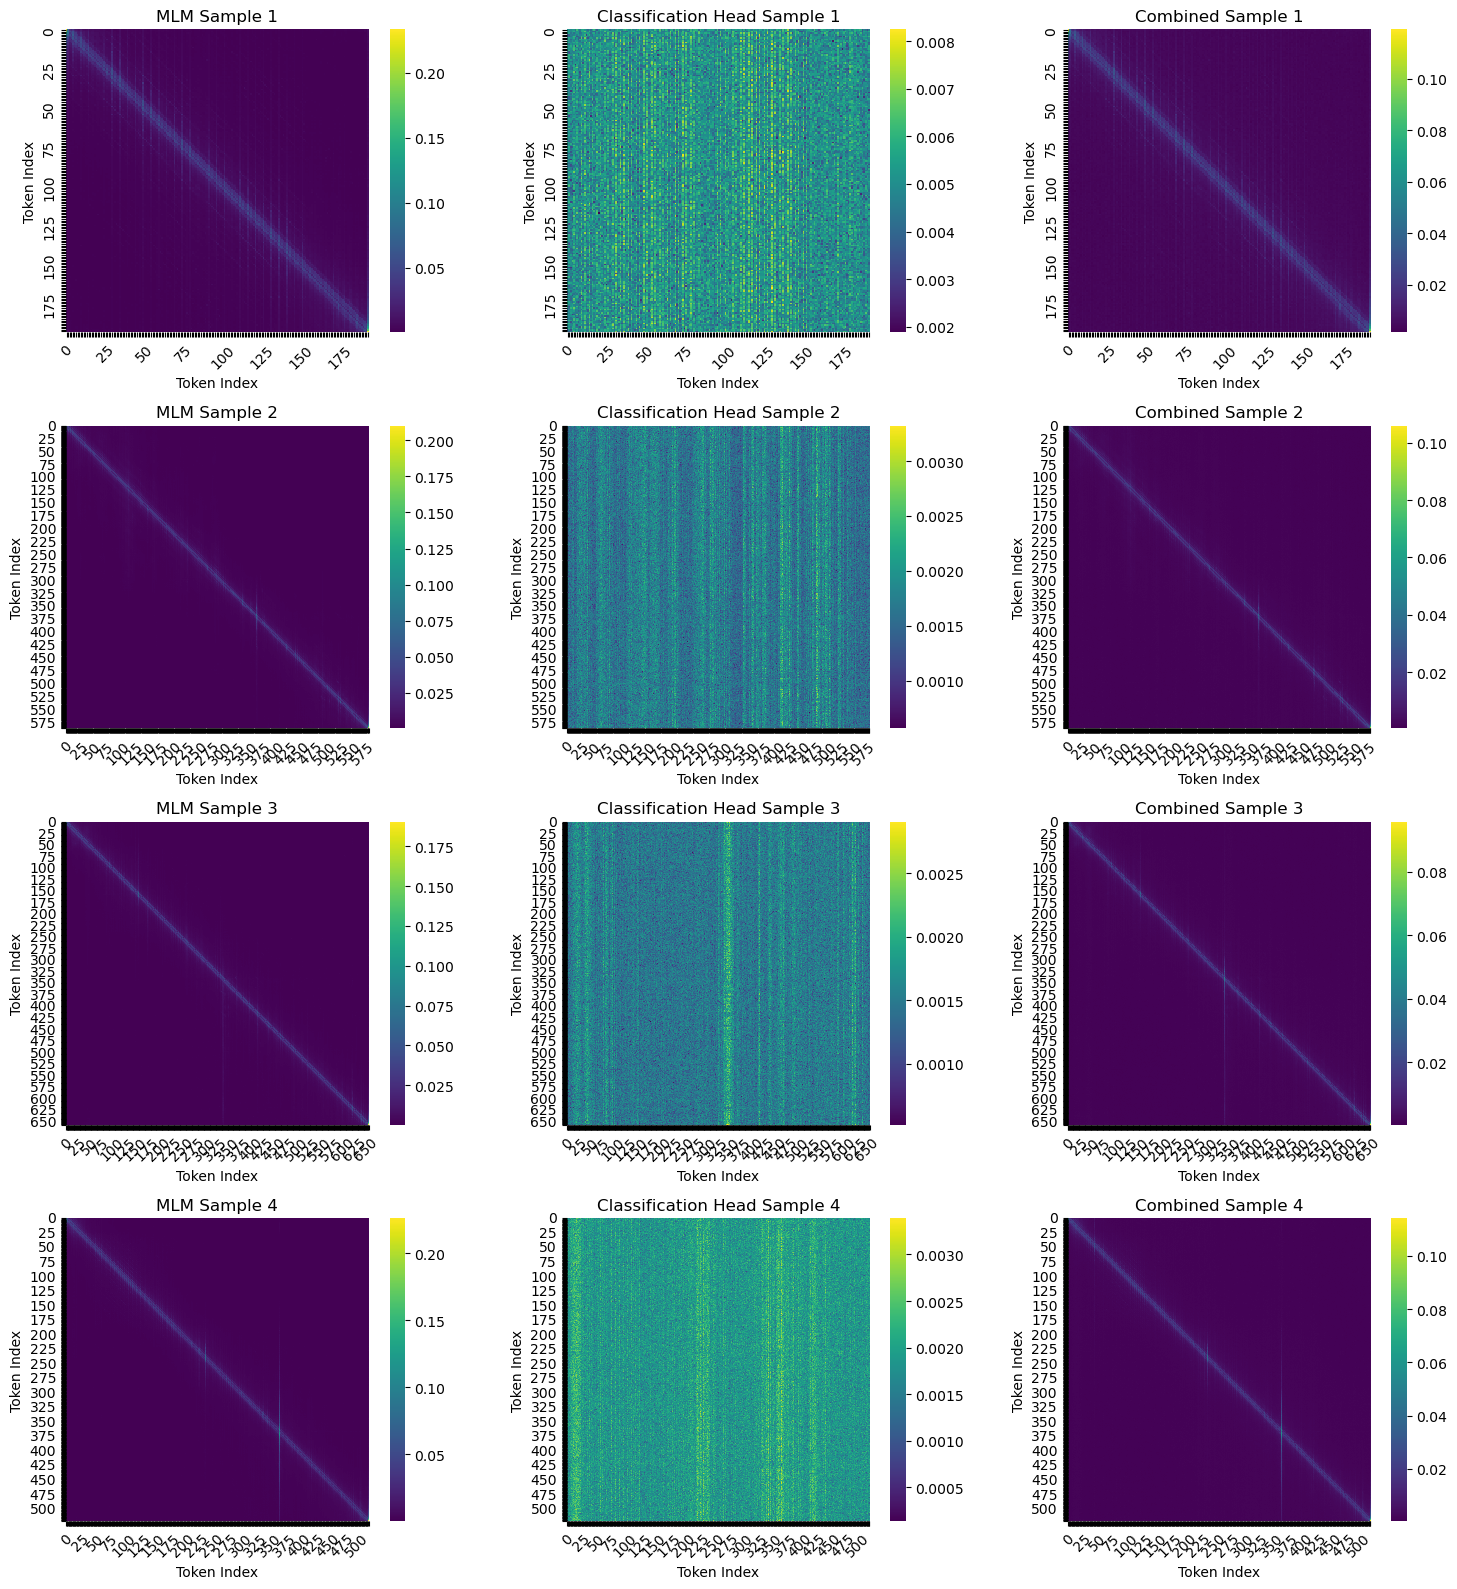

In [9]:
helper_functions.plot_attention_maps(weights, attention_masks, tick_spacing=25)  # Adjust spacing as needed

### Motif Plots
Now that our model has provided regions of the sequence it deems important for classification, we can analyze how this lines up with the original amino acid sequence through motif plots. The motif plots are created with a cubed normalization strategy to really emphasize high importance tokens.

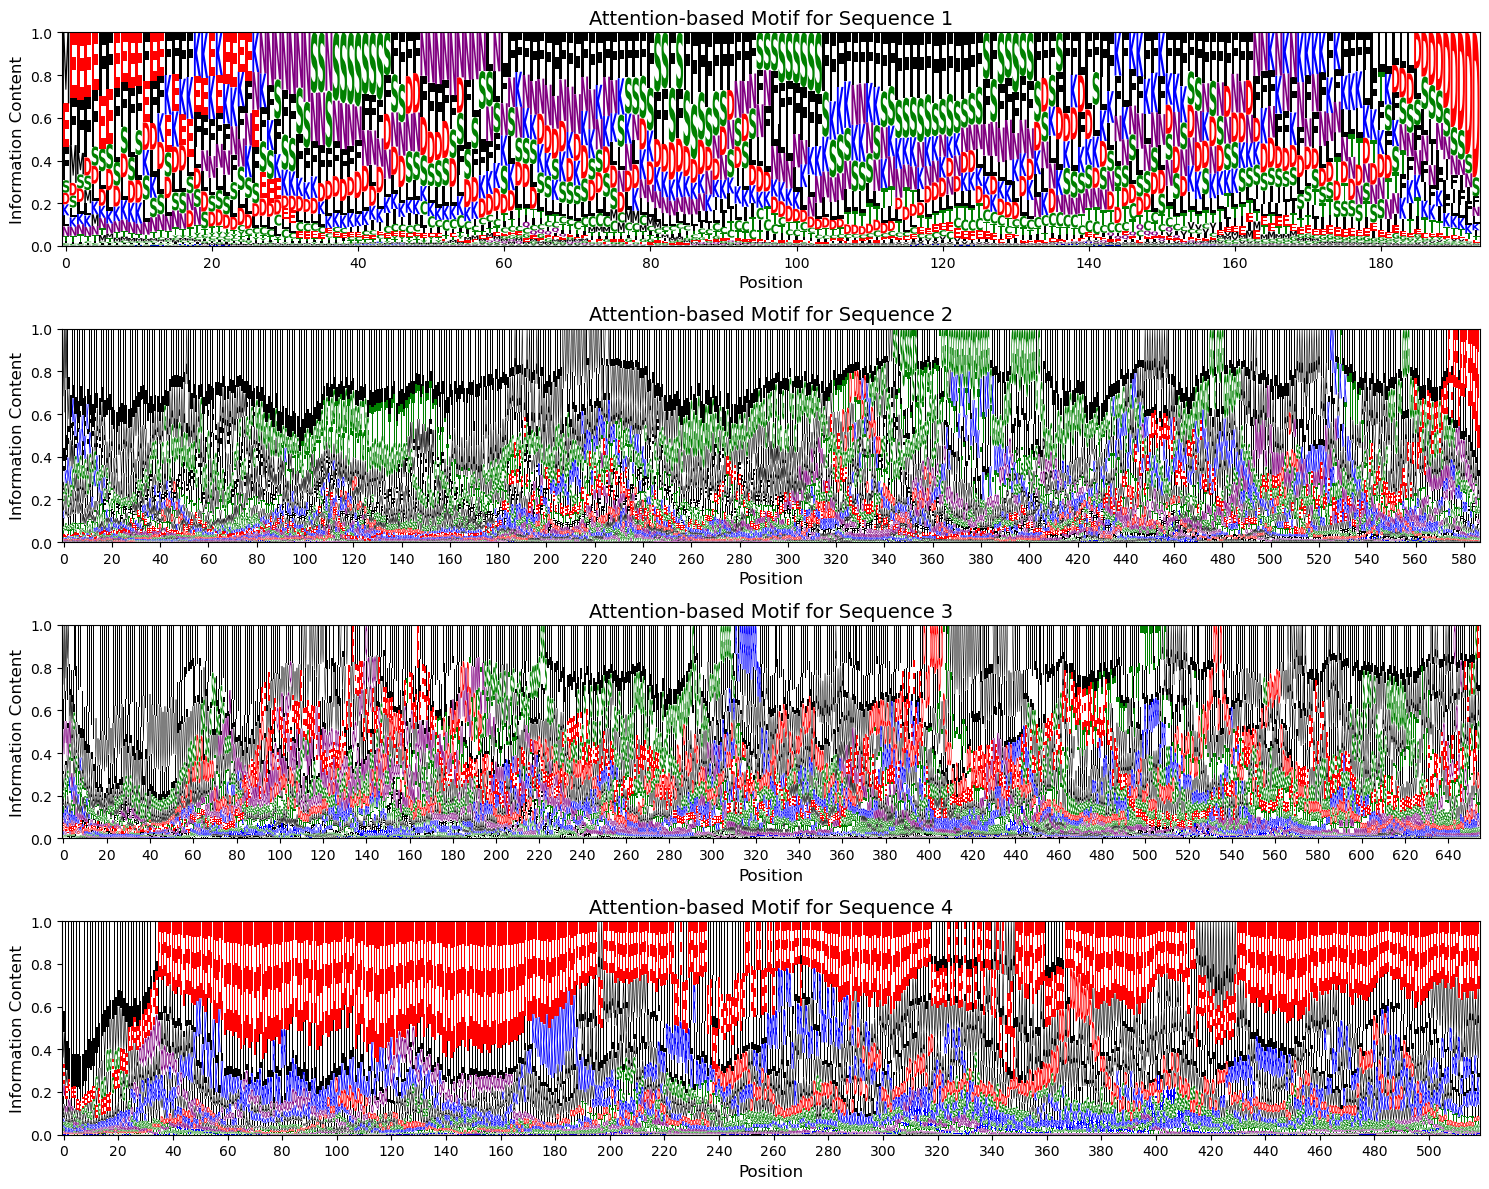

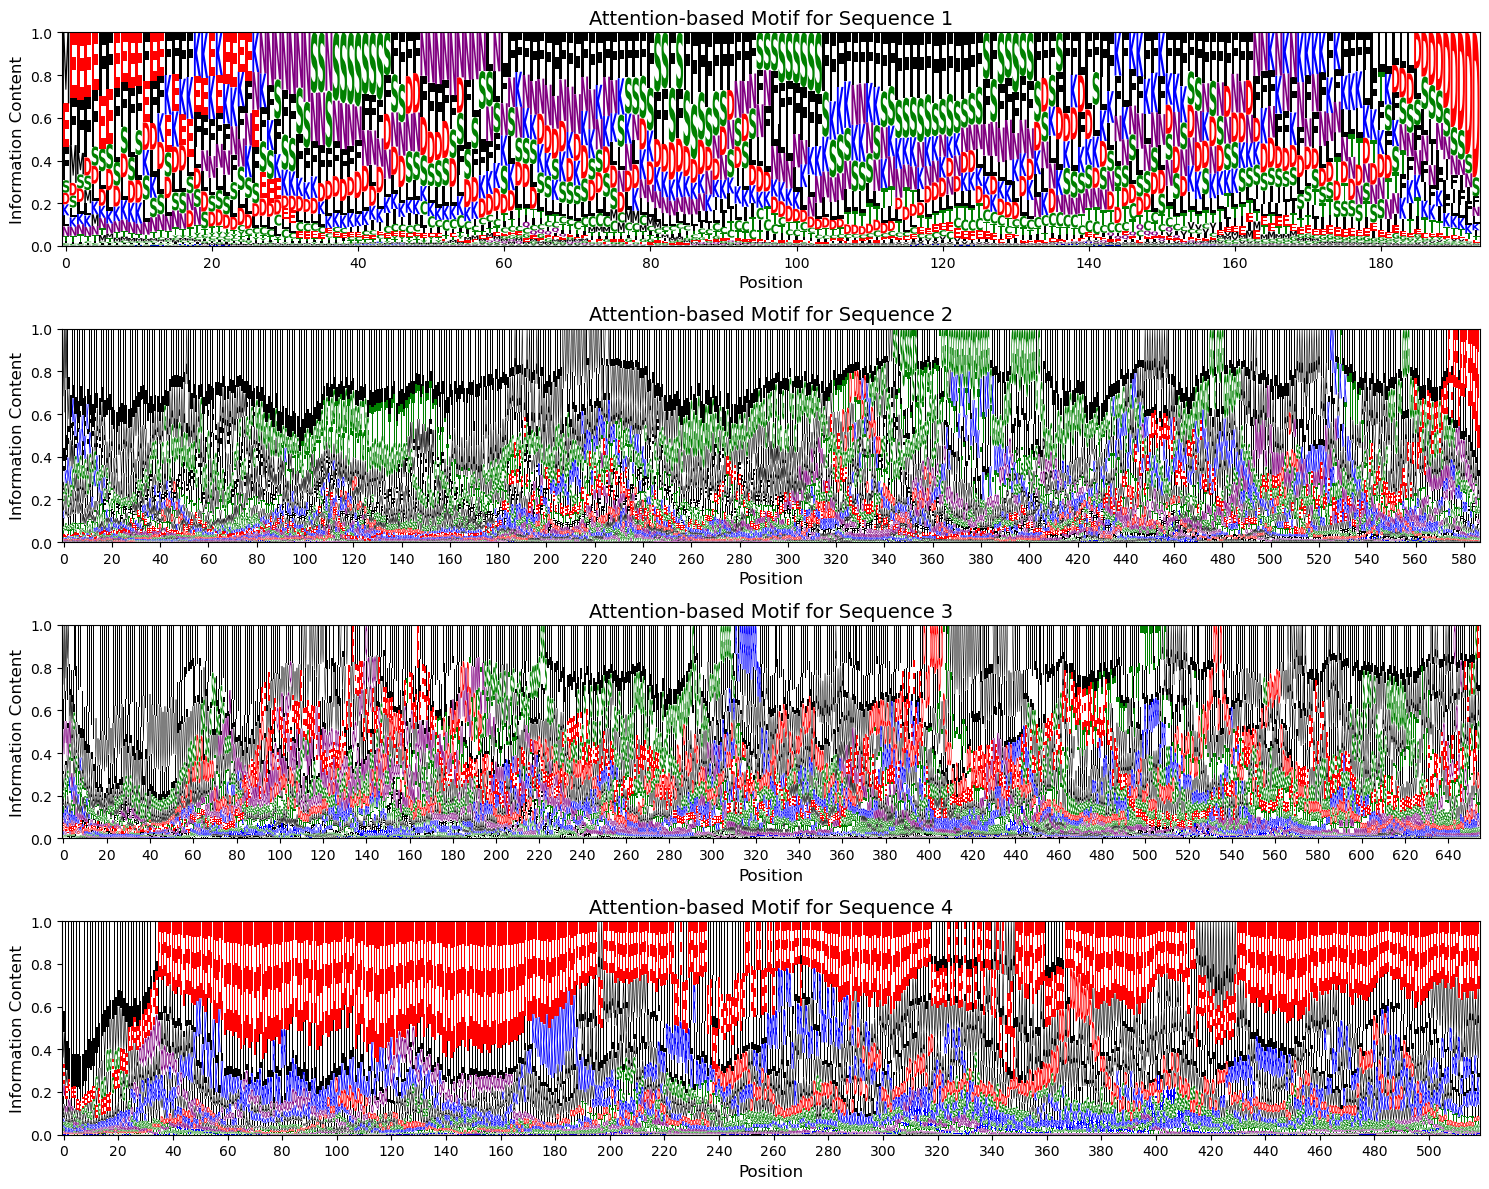

In [10]:
helper_functions.motif_plot(weights, attention_masks, data['sequence'])

### Interpetability?
Unfortunately, our attention matrices and motif plots appear quite noisy. This is likely due to our training objective and our use of ESM as a fine-tuning base. Using ESM means that our classification head is making decisions by essentially piecing together already abstracted features, which makes interpretability quite hard for humans. The features being recognized likely rely on many tokens and motifs throughout the sequence, making it difficult to visualize in an interpretable manor. There are other visualization techniques or stastistical methods that might provide us with greater meaning from our attention and motif plots; however, those techniques are outside of the scale of this project.